In [42]:
# Epale Mario! mi piernita

import argparse
import yaml
import time
import datetime
import cv2
import numpy as np
import pandas as pd
import random

from skimage import io, transform
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy import ndimage, misc

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch
from torch.autograd import Variable
import torch.optim as optim

from google.colab import drive
import os

import warnings
from collections import defaultdict

from scipy import stats
from sklearn.metrics import mean_absolute_error

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/Mosquito-Tec/DA-RNN')

Mounted at /content/drive


In [0]:
# Open Data

train_csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_train6_W.csv'
train_frame = pd.read_csv(train_csv_file)

train_frame["TRAPSET"] = pd.to_datetime(train_frame["TRAPSET"])
train_frame["TRAPCOLLECT"] = pd.to_datetime(train_frame["TRAPCOLLECT"])

train_frame["TRAPDAYS"] = (train_frame["TRAPCOLLECT"] - train_frame["TRAPSET"]).dt.days

train_frame["TRAPSET"] = train_frame["TRAPSET"].dt.week
train_frame["TRAPCOLLECT"] = train_frame["TRAPCOLLECT"].dt.week

# Test data

test_csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_test6_W.csv'
test_frame = pd.read_csv(test_csv_file)

test_frame["TRAPSET"] = pd.to_datetime(test_frame["TRAPSET"])
test_frame["TRAPCOLLECT"] = pd.to_datetime(test_frame["TRAPCOLLECT"])

test_frame["TRAPDAYS"] = (test_frame["TRAPCOLLECT"] - test_frame["TRAPSET"]).dt.days

test_frame["TRAPSET"] = test_frame["TRAPSET"].dt.week
test_frame["TRAPCOLLECT"] = test_frame["TRAPCOLLECT"].dt.week

In [0]:
non_temporal_columns = ["OBJECTID", "X", "Y", "TRAPTYPE", "ATTRACTANTUSED",
                        "TRAPID", "LATITUDE", "LONGITUDE", "ADDRESS", "TOWN",
                        "STATE", "COUNTY", "TRAPSITE", "TRAPSET", "SETTIMEOFDAY",
                        "YEAR", "TRAPCOLLECT", "COLLECTTIMEOFDAY", "GENUS",
                        "SPECIES", "LIFESTAGE", "EGGSCOLLECTED", "LARVAECOLLECTED",
                        "PUPAECOLLECTED", "REPORTDATE", "TRAPDAYS"]

non_num_columns = ["LATITUDE", "LONGITUDE", "TRAPDAYS", "TRAPSET"]

categorical_columnsT = ["TRAPTYPE", "ATTRACTANTSUSED", "TRAPID", "ADDRESS", "TOWN",
                        "STATE", "COUNTY", "TRAPSITE", "TRAPSET", "SETTIMEOFDAY",
                        "TRAPCOLLECT", "COLLECTTIMEOFDAY", "GENUS",
                        "SPECIES", "LIFESTAGE", "EGGSCOLLECTED", "LARVAECOLLECTED",
                        "PUPAECOLLECTED", "REPORTDATE"]

categorical_columns = ["TRAPTYPE", "ATTRACTANTSUSED"]

temporal_columns = ["sunriseTime", "sunsetTime", "moonPhase", "precipIntensity",
                    "precipIntensityMax", "precipProbability", "temperatureHigh",
                    "temperatureHighTime", "temperatureLow", "temperatureLowTime",
                    "apparentTemperatureHigh", "apparentTemperatureHighTime",
                    "apparentTemperatureLow", "apparentTemperatureLowTime",
                    "dewPoint", "humidity", "pressure", "windSpeed", "windGust",
                    "windGustTime", "windBearing", "cloudCover", "uvIndex", 
                    "uvIndexTime", "visibility", "temperatureMin", "temperatureMinTime",
                    "temperatureMax", "temperatureMaxTime", "apparentTemperatureMin",
                    "apparentTemperatureMinTime", "apparentTemperatureMax", "apparentTemperatureMaxTime",
                    "icon", "time", "precipIntensityMaxTime", "precipType", "summary"] 

numerical_columns = ["temperatureHigh", "uvIndex", "precipIntensity", "precipIntensityMaxTime",
                     "sunriseTime", "temperatureLow", "humidity"]

output_column = "TOTAL"

In [0]:
SEQ_LENGTH = 14
NUM_ENTRIES = train_frame.shape[0]

column_means = {}
column_maxs = {}
column_mins = {}

for col in numerical_columns:
    column_means[col] = 0
    column_maxs[col] = 0
    column_mins[col] = np.inf

    for i in range(1, SEQ_LENGTH + 1):
        train_frame[col + str(i)].replace(to_replace=r'No*', value=np.nan, regex=True, inplace=True)
        test_frame[col + str(i)].replace(to_replace=r'No*', value=np.nan, regex=True, inplace=True)

        if(train_frame[col + str(i)].dtype == np.dtype(object)):
            train_frame[col + str(i)] = train_frame[col + str(i)].astype("float64", copy="False")

        if(test_frame[col + str(i)].dtype == np.dtype(object)):
            test_frame[col + str(i)] = test_frame[col + str(i)].astype("float64", copy="False")

        cur_col = train_frame[col + str(i)]

        col_mean = cur_col.mean()

        train_frame[col + str(i)].replace(to_replace=np.nan, value=0.0, inplace=True)
        test_frame[col + str(i)].replace(to_replace=np.nan, value=0.0, inplace=True)

        column_means[col] += col_mean * NUM_ENTRIES
        if cur_col.max() > column_maxs[col]:
            column_maxs[col] = cur_col.max()

        if cur_col.min() < column_mins[col]:
            column_mins[col] = cur_col.min()

    column_means[col] /= SEQ_LENGTH * NUM_ENTRIES

    for i in range(1, SEQ_LENGTH + 1):
        test_frame[col + str(i)] = (test_frame[col + str(i)] - column_means[col]) / (column_maxs[col] - column_mins[col])
        train_frame[col + str(i)] = (train_frame[col + str(i)] - column_means[col]) / (column_maxs[col] - column_mins[col])


In [0]:
# Standardize Numerical Columns (not Temporal)

num_means = {}
num_maxs = {}
num_mins = {}

for col in non_num_columns:
    cur_col = train_frame[col]
    num_means[col] = cur_col.mean()
    num_maxs[col] = cur_col.max()
    num_mins[col] = cur_col.min()

    train_frame[col] = (cur_col - num_means[col]) / (num_maxs[col] - num_mins[col])
    test_frame[col] = (test_frame[col] - num_means[col]) / (num_maxs[col] - num_mins[col])

In [69]:
# Convert categories
ats_train = []
ats_test = []

for category in categorical_columns:
    train_frame[category] = train_frame[category].astype('category')
    test_frame[category] = test_frame[category].astype('category')
    ats_train.append(train_frame[category].cat.codes.values)
    ats_test.append(test_frame[category].cat.codes.values)

train_cat = np.stack(ats_train, 1)
test_cat = np.stack(ats_test, 1)

categorical_column_sizes = [len(train_frame[column].cat.categories) for column in categorical_columns]
embedding_sizes = [(col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_column_sizes]

print(embedding_sizes)

[(3, 2), (4, 2)]


## Graphing

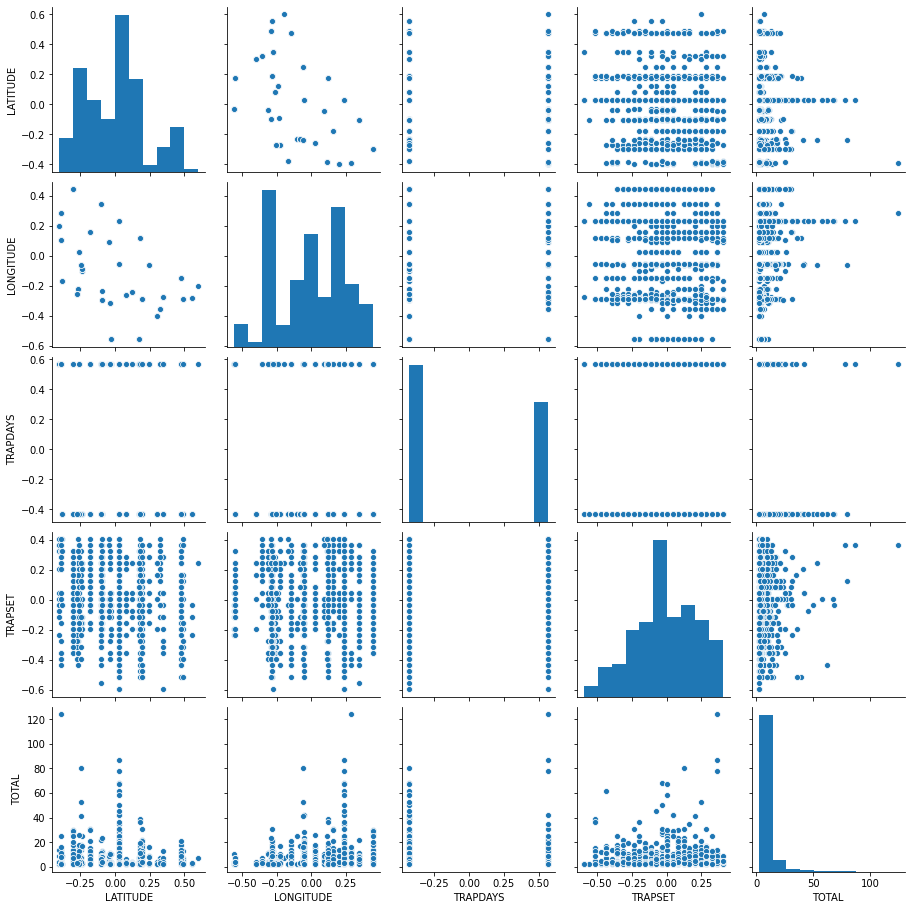

In [49]:
graph_columns = ["LATITUDE", "LONGITUDE", "TRAPDAYS", "TRAPSET", "TOTAL"]

sns.pairplot(train_frame[graph_columns])

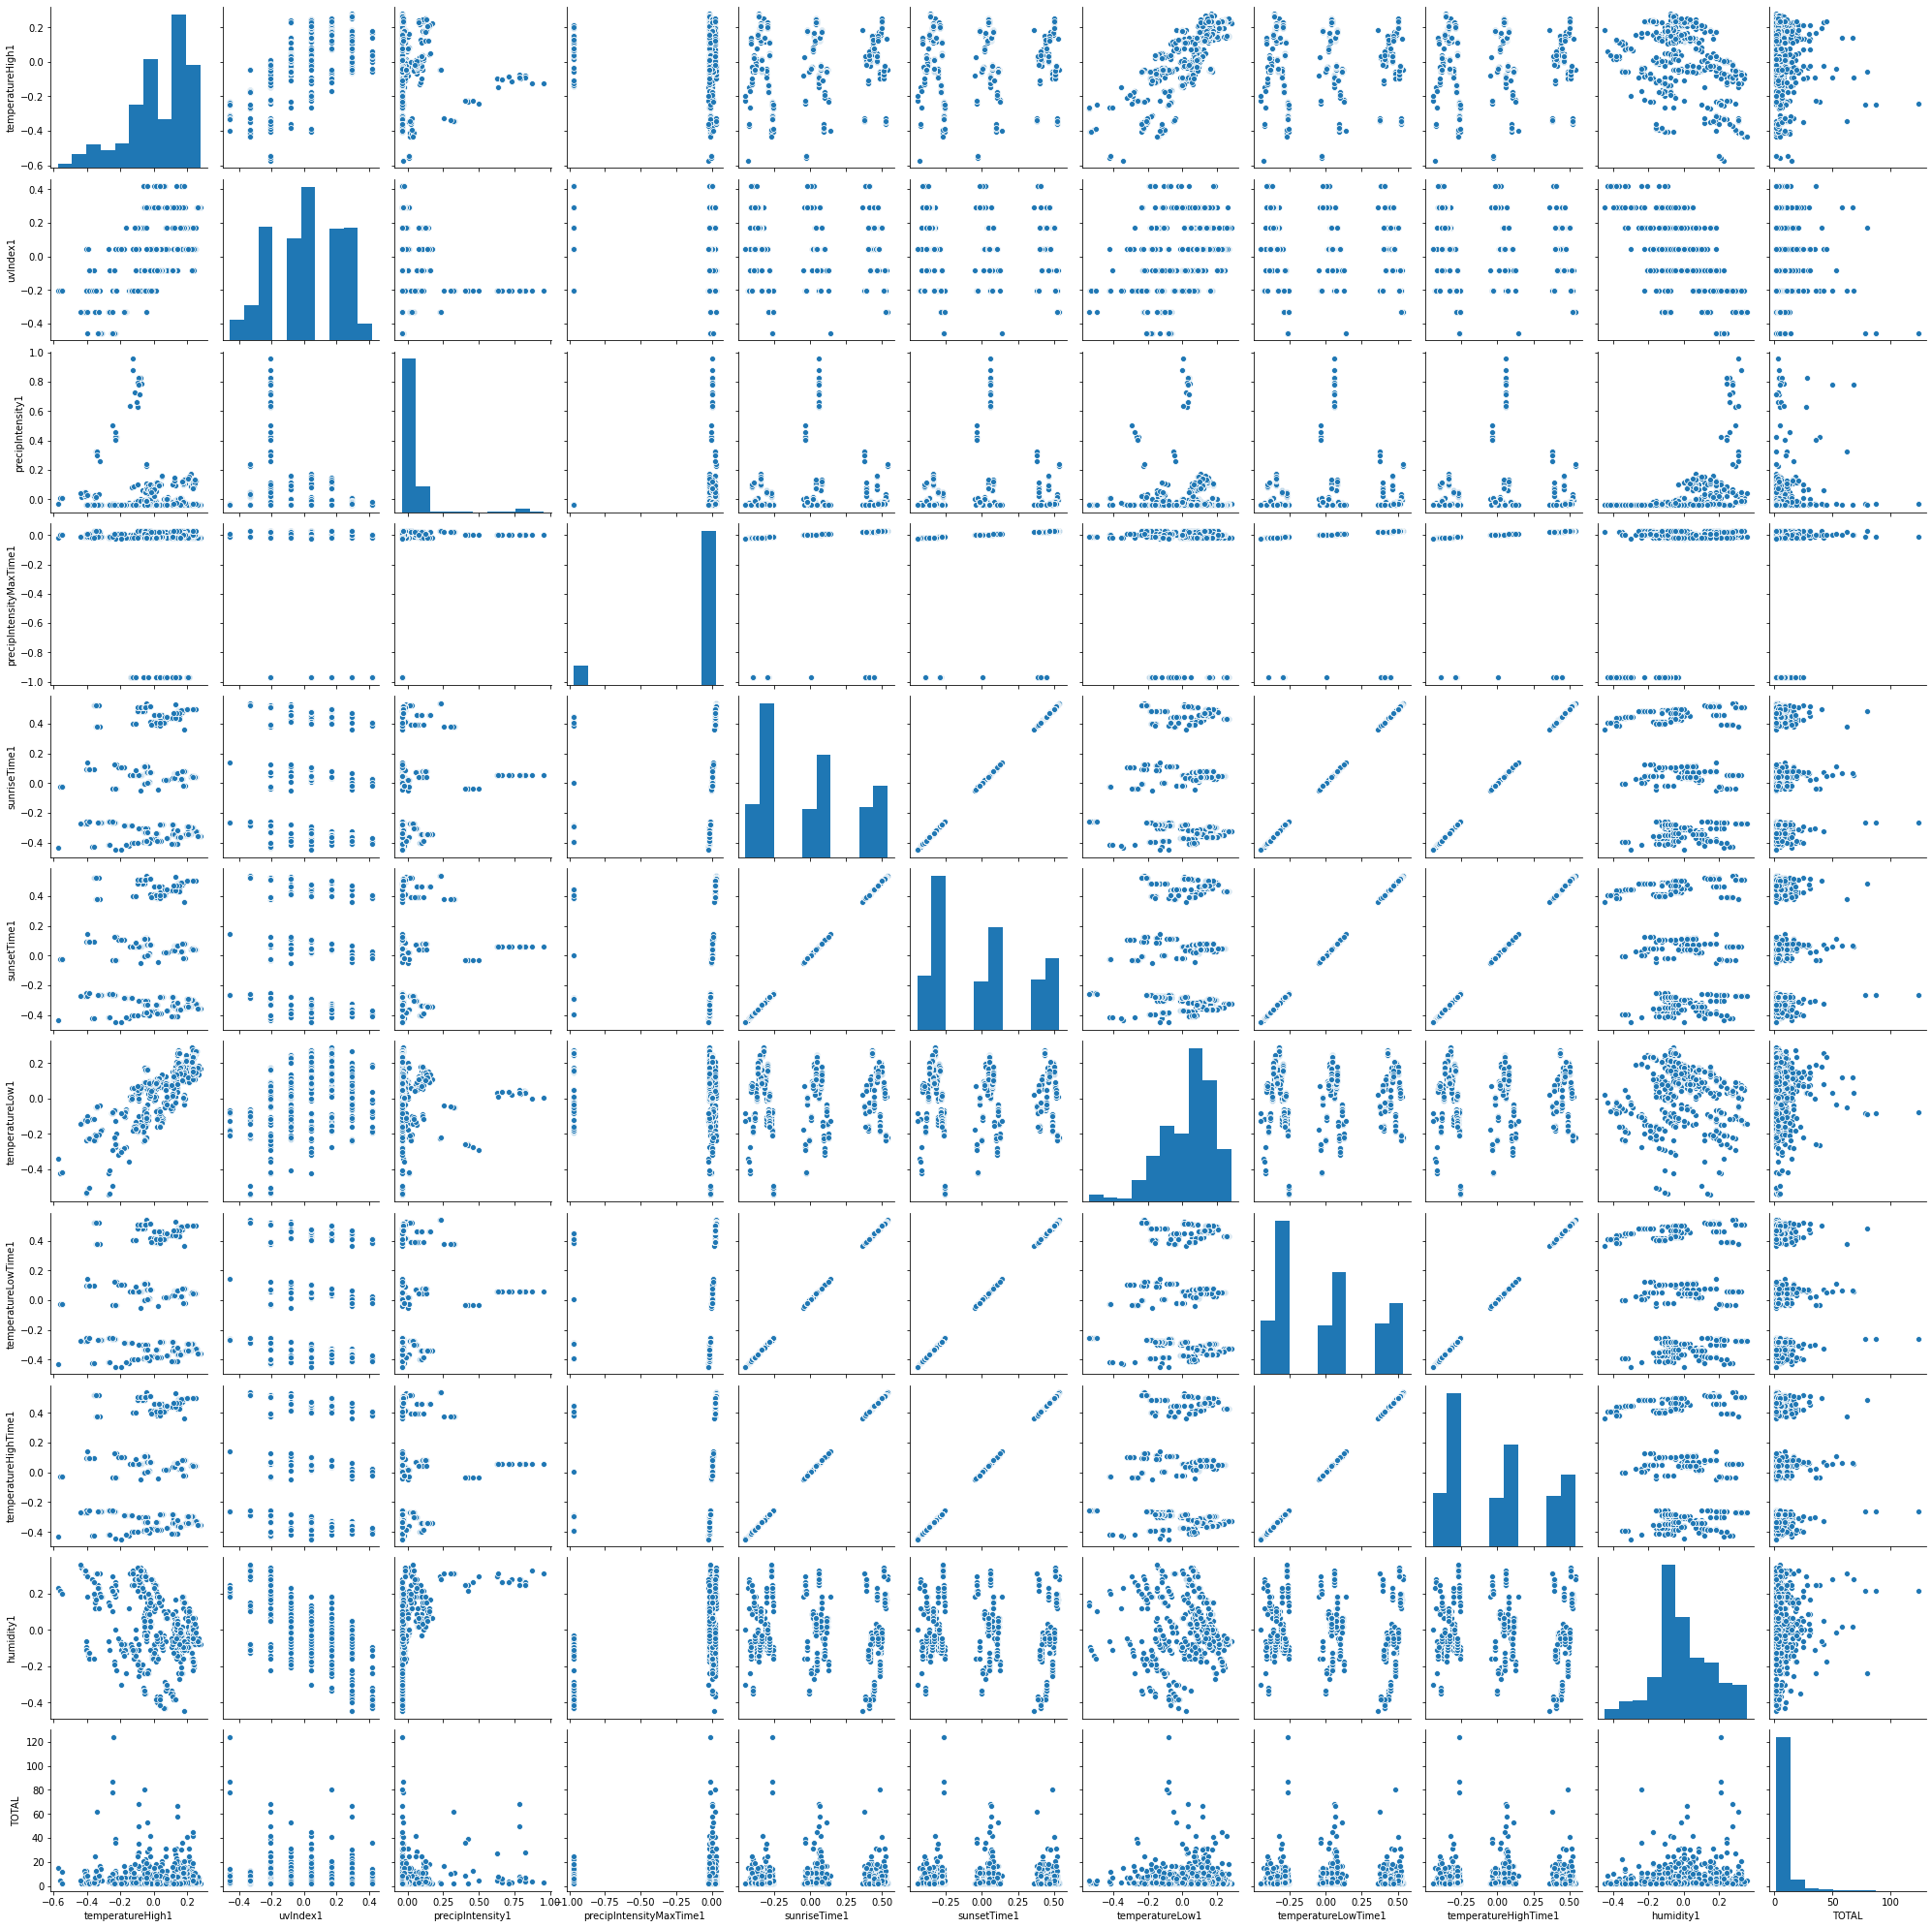

In [50]:
graph_columns = ["temperatureHigh1", "uvIndex1", "precipIntensity1", "precipIntensityMaxTime1",
                 "sunriseTime1", "sunsetTime1", "temperatureLow1", "temperatureLowTime1",
                 "temperatureHighTime1", "humidity1", "TOTAL"]

sns.pairplot(train_frame[graph_columns])

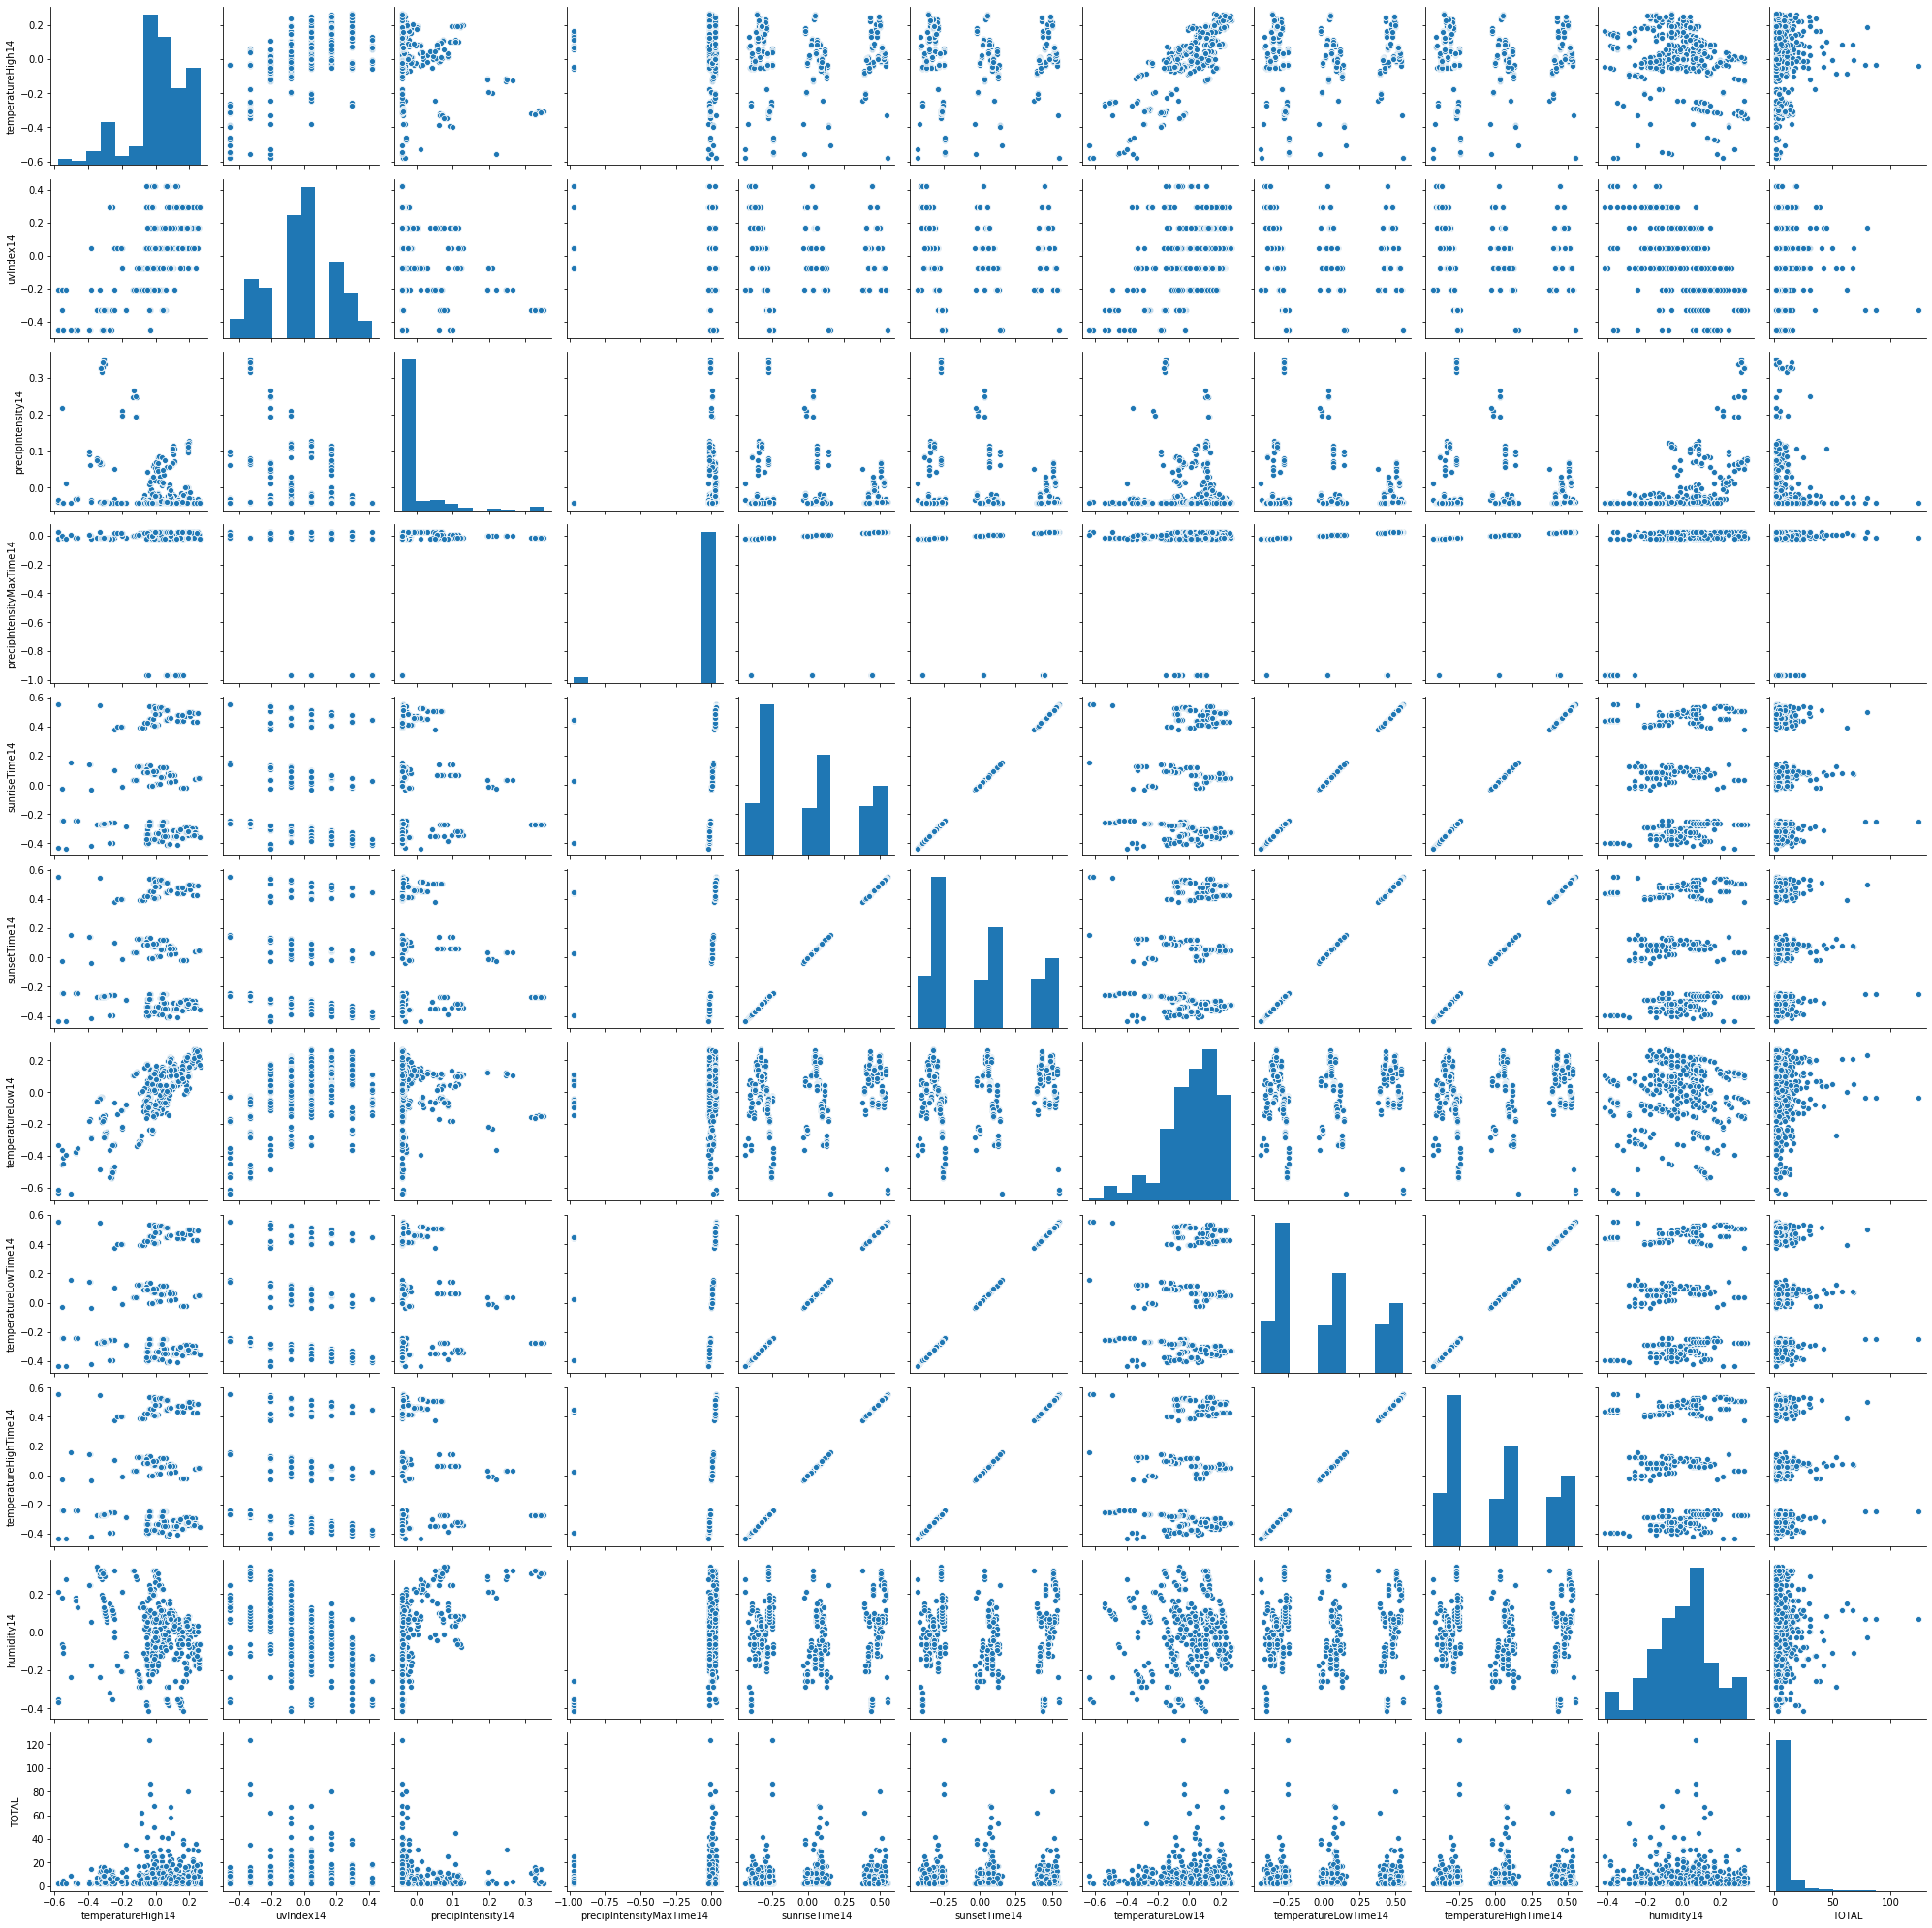

In [51]:
graph_columns = ["temperatureHigh14", "uvIndex14", "precipIntensity14", "precipIntensityMaxTime14",
                 "sunriseTime14", "sunsetTime14", "temperatureLow14", "temperatureLowTime14",
                 "temperatureHighTime14", "humidity14", "TOTAL"]

sns.pairplot(train_frame[graph_columns])

In [0]:
# Organize info by batches/sequences
# Shape [784, 14, 35] -> Train

#train_features = np.zeros(shape=(train_frame.shape[0], SEQ_LENGTH, len(numerical_columns)+len(non_num_columns)))
#test_features = np.zeros(shape=(test_frame.shape[0], SEQ_LENGTH, len(numerical_columns)+len(non_num_columns)))

train_features = np.zeros(shape=(train_frame.shape[0], SEQ_LENGTH, len(numerical_columns)))
test_features = np.zeros(shape=(test_frame.shape[0], SEQ_LENGTH, len(numerical_columns)))

for i in range(1, SEQ_LENGTH + 1):
    for row, col in enumerate(numerical_columns):
        train_features[:, i-1, row] = train_frame[col + str(i)]
        test_features[:, i-1, row] = test_frame[col + str(i)]

    '''    
    for row, col in enumerate(non_num_columns):
        train_features[:, i-1, row+len(numerical_columns)] = train_frame[col]
        test_features[:, i-1, row+len(numerical_columns)] = test_frame[col]
    '''

In [0]:
# Organize info that is not temporal
train_y = train_frame["TOTAL"].to_numpy()
test_y = test_frame["TOTAL"].to_numpy()

train_X = np.zeros(shape=(train_frame.shape[0], len(non_num_columns)))
test_X = np.zeros(shape=(test_frame.shape[0], len(non_num_columns)))

for row, col in enumerate(non_num_columns):
    train_X[:, row] = train_frame[col]
    test_X[:, row] = test_frame[col]

### Danger! Cuau Validation: DNR

In [72]:
# Create DataLoaders
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2


# obtain training indices that will be used for validation
num_train = len(train_X)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print(len(train_idx), len(valid_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_data = TensorDataset(torch.from_numpy(train_features), 
                           torch.from_numpy(train_X), 
                           torch.from_numpy(train_cat),
                           torch.from_numpy(train_y))

test_data = TensorDataset(torch.from_numpy(test_features), 
                          torch.from_numpy(test_X), 
                          torch.from_numpy(test_cat),
                          torch.from_numpy(test_y))


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
    sampler = train_sampler, num_workers = num_workers, drop_last=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
    sampler = valid_sampler, num_workers = num_workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, 
    num_workers = num_workers, shuffle = False, drop_last=True)

596 149


In [0]:
# Create DataLoaders
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 4
# percentage of training set to use as validation
valid_size = 0.15


# obtain training indices that will be used for validation
num_train = len(train_X)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print(len(train_idx), len(valid_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_data = TensorDataset(torch.from_numpy(train_features[train_idx]), 
                           torch.from_numpy(train_X[train_idx]), 
                           torch.from_numpy(train_cat[train_idx]),
                           torch.from_numpy(train_y[train_idx]))

valid_data = TensorDataset(torch.from_numpy(train_features[valid_idx]), 
                           torch.from_numpy(train_X[valid_idx]), 
                           torch.from_numpy(train_cat[valid_idx]),
                           torch.from_numpy(train_y[valid_idx]))

test_data = TensorDataset(torch.from_numpy(test_features), 
                          torch.from_numpy(test_X), 
                          torch.from_numpy(test_cat),
                          torch.from_numpy(test_y))

print(len(train_data), len(valid_data))

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False, drop_last=True)

634 111
634 111


In [0]:
dataiter = iter(train_loader)
sample_features, sample_X, sample_cat, sample_y = dataiter.next()

In [0]:
print(sample_features.shape)
print(sample_X.shape)
print(sample_cat.shape)
print(sample_y.shape)

torch.Size([16, 14, 5])
torch.Size([16, 3])
torch.Size([16, 2])
torch.Size([16])


In [55]:
# First checking if GPU is available
train_on_gpu = torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

#train_on_gpu = False

Training on GPU.


In [0]:
class MosquitoLSTM(nn.Module):
    def __init__(self, num_numerical_columns, hidden_dim, n_layers):
        super(MosquitoLSTM, self).__init__()

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        '''
        embed_size = 0
        for embed in embedding_sizes:
            embed_size += embed[1]

        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])
        '''

        # For LSTM
        self.lstm = nn.LSTM(num_numerical_columns, hidden_dim, n_layers,
                            dropout=0.3, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)

        self.dense = nn.Sequential(
            
            nn.Linear(hidden_dim, 1)
        )
        self.ReLU = nn.ReLU()

    def forward(self, X_temp, hidden):
        lstm_out, hidden = self.lstm(X_temp, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        print(lstm_out.shape)
        # dropout and fully-connected layer
        out = self.dense(lstm_out)
        # sigmoid function
        out = self.ReLU(out)
        
        print(out.shape)
        # reshape to be batch_size first
        out = out.view(batch_size, -1)
        print(out.shape)
        out = out[:, -1]
        print(out.shape)



        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden


In [0]:
class MosquitoRedux(nn.Module):
    def __init__(self, 
                 lstm_columns, lstm_hidden_dim, lstm_n_layers,
                 num_columns, num_hidden_dim,
                 embedding_sizes, cat_hidden_dim):
        super(MosquitoRedux, self).__init__()

        self.lstm_n_layers = lstm_n_layers
        self.lstm_hidden_dim = lstm_hidden_dim

        self.num_hidden_dim = num_hidden_dim
        self.cat_hidden_dim = cat_hidden_dim

        embed_size = 0
        for embed in embedding_sizes:
            embed_size += embed[1]

        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])

        # For LSTM
        self.lstm = nn.LSTM(lstm_columns, lstm_hidden_dim, lstm_n_layers,
                            dropout=0.3, batch_first=True)
        
        # LSTM dense layer
        self.lstm_dense = nn.Sequential(
            nn.BatchNorm1d(lstm_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(lstm_hidden_dim, 1),
            nn.ReLU()
        )
        
        self.num_dense = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_columns, num_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(num_hidden_dim, num_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(num_hidden_dim, num_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_hidden_dim),
            nn.Linear(num_hidden_dim, 1),
            nn.ReLU()
        )

        self.cat_dense = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(embed_size, cat_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(cat_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(cat_hidden_dim, cat_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(cat_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(cat_hidden_dim, cat_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(cat_hidden_dim),
            nn.Linear(cat_hidden_dim, 1),
            nn.ReLU()
        )

    def forward(self, X_temp, hidden, X_num, X_cat):
        # Forward lstm
        lstm_out, hidden = self.lstm(X_temp, hidden)
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.lstm_hidden_dim)
        # dropout and fully-connected layer
        lstm_out = self.lstm_dense(lstm_out)
      
        # reshape to be batch_size first
        lstm_out = lstm_out.view(batch_size, -1)
        lstm_out = lstm_out[:, -1]
        lstm_out = lstm_out.view(batch_size, -1)

        # Forward num
        num_out = self.num_dense(X_num)

        # Forward cat
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embed = e(X_cat[:, i])
            embeddings.append(embed)

        cat_out = torch.cat(embeddings, 1)
        cat_out = self.cat_dense(cat_out)

        return lstm_out, hidden, num_out, cat_out

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_().cuda(),
                  weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_(),
                      weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_())
        
        return hidden

In [0]:
# Instantiate the model w/ hyperparams
a_h = 3

lstm_hidden_dim = np.int(len(train_idx) / (a_h * len(numerical_columns) + 1))
print(lstm_hidden_dim)
lstm_n_layers = 2

num_hidden_dim = 15
cat_hidden_dim = 15

#net = MosquitoLSTM(len(numerical_columns), hidden_dim, n_layers).double()
net = MosquitoRedux(
    len(numerical_columns), lstm_hidden_dim, lstm_n_layers,
    len(non_num_columns), num_hidden_dim,
    embedding_sizes, cat_hidden_dim
).double()

weight_lstm = 1.0
weight_num = 2.0
weight_cat = 1.0

21


In [0]:
lr = 0.001

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)

In [0]:
# training params

epochs = 400 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 10
clip = 10 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
valid_loss_min = np.Inf

for epoch in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    train_loss = 0.0
    valid_loss = 0.0

    net.train()

    # batch loop
    for X_temp, X_num, X_cat, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        lstm_output, h, num_output, cat_output = net(X_temp, h, X_num, X_cat)

        output = (weight_lstm*lstm_output + weight_num*num_output + weight_cat*cat_output) 

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.double())
        loss.backward()
        train_loss += loss.item()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

    net.eval()

    val_h = net.init_hidden(batch_size)

    for X_temp, X_num, X_cat, labels in valid_loader:
        
        
        if(train_on_gpu):
            X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data for each in val_h])

        # get the output from the model
        lstm_output, h, num_output, cat_output = net(X_temp, h, X_num, X_cat)

        # calculate the loss and perform backprop
        output = (weight_lstm*lstm_output + weight_num*num_output + weight_cat*cat_output) 
        loss = criterion(output.squeeze(), labels.double())
        valid_loss += loss.item()

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'lstm_test.pt')
        valid_loss_min = valid_loss
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

Validation loss decreased (inf --> 1063.810599).  Saving model ...
Epoch: 0 	Training Loss: 4902.986458 	Validation Loss: 1063.810599
Validation loss decreased (1063.810599 --> 1010.740524).  Saving model ...
Epoch: 1 	Training Loss: 4528.126603 	Validation Loss: 1010.740524
Epoch: 2 	Training Loss: 4321.250742 	Validation Loss: 1019.153390
Validation loss decreased (1010.740524 --> 790.559787).  Saving model ...
Epoch: 3 	Training Loss: 4298.738146 	Validation Loss: 790.559787
Validation loss decreased (790.559787 --> 788.113032).  Saving model ...
Epoch: 4 	Training Loss: 4151.630487 	Validation Loss: 788.113032
Epoch: 5 	Training Loss: 4001.181914 	Validation Loss: 942.267813
Epoch: 6 	Training Loss: 4183.231023 	Validation Loss: 953.540055
Epoch: 7 	Training Loss: 4021.229664 	Validation Loss: 910.900171
Epoch: 8 	Training Loss: 4069.782589 	Validation Loss: 942.354421
Epoch: 9 	Training Loss: 4039.964342 	Validation Loss: 968.322827
Epoch: 10 	Training Loss: 3960.657928 	Validatio

In [0]:
net.load_state_dict(torch.load('lstm_test.pt'))

<All keys matched successfully>

In [0]:


# track test loss
test_loss = 0.0
mean_abs = 0.0

net.eval()
# iterate over test data
#bin_op.binarization()
test_h = net.init_hidden(batch_size)

for batch_idx, (X_temp, X_num, X_cat, labels) in enumerate(test_loader):
    if(train_on_gpu):
        X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()
    
    test_h = tuple([each.data for each in test_h])

    # get the output from the model
    lstm_output, h, num_output, cat_output = net(X_temp, h, X_num, X_cat)

    output = (weight_lstm*lstm_output + weight_num*num_output + weight_cat*cat_output) 
    # / (weight_lstm + weight_num + weight_cat)

    # calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.double())

    out_np = output.detach().squeeze().cpu().numpy().astype(int).T
    target_np = labels.detach().cpu().numpy().astype(int).T

    print([(out, tar) for out, tar in zip(out_np, target_np)])

    mean_abs += mean_absolute_error(out_np, target_np) * batch_size
        
    test_loss += loss.item() * batch_size

# calculate average losses
test_loss = np.sqrt(test_loss / len(test_loader.dataset))
mean_abs /= len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Mean Abs Loss: {:.6f}\n'.format(mean_abs))

[(4, 3), (4, 3), (3, 2), (6, 2), (5, 2), (5, 3), (6, 3), (2, 3), (2, 2), (2, 6), (2, 4), (2, 4), (2, 5), (2, 3), (2, 2), (5, 16)]
[(4, 4), (2, 10), (2, 5), (2, 3), (2, 8), (9, 2), (6, 9), (2, 66), (7, 3), (5, 9), (5, 11), (5, 8), (4, 25), (4, 4), (8, 3), (7, 2)]
[(7, 3), (6, 3), (7, 6), (8, 3), (8, 8), (8, 8), (7, 6), (7, 9), (8, 12), (8, 18), (7, 24), (7, 19), (7, 3), (7, 15), (8, 12), (8, 12)]
[(7, 17), (7, 9), (7, 3), (7, 12), (7, 33), (7, 11), (7, 6), (7, 2), (7, 7), (7, 5), (7, 2), (8, 11), (8, 23), (8, 4), (7, 7), (7, 5)]
[(6, 6), (7, 10), (7, 12), (6, 5), (7, 10), (5, 2), (7, 3), (7, 32), (7, 13), (5, 27), (8, 9), (8, 12), (5, 16), (8, 6), (5, 3), (7, 7)]
[(5, 2), (5, 6), (7, 10), (7, 6), (7, 2), (4, 3), (5, 5), (7, 2), (7, 5), (4, 17), (7, 18), (7, 3), (4, 8), (7, 2), (7, 15), (4, 5)]
Test Loss: 8.987268

Mean Abs Loss: 4.809524



## Mixed Model

In [0]:
class MosquitoMixed(nn.Module):
    def __init__(self, 
                 lstm_columns, lstm_hidden_dim, lstm_n_layers, lstm_output,
                 num_columns, num_hidden_dim,
                 embedding_sizes, cat_hidden_dim,
                 combined_dim):
        super(MosquitoMixed, self).__init__()

        self.lstm_n_layers = lstm_n_layers
        self.lstm_hidden_dim = lstm_hidden_dim

        self.num_hidden_dim = num_hidden_dim
        self.cat_hidden_dim = cat_hidden_dim

        embed_size = 0
        for embed in embedding_sizes:
            embed_size += embed[1]

        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])

        # For LSTM
        self.lstm = nn.LSTM(lstm_columns, lstm_hidden_dim, lstm_n_layers,
                            dropout=0.3, batch_first=True)
        
        # LSTM dense layer
        self.lstm_dense = nn.Sequential(
            nn.BatchNorm1d(lstm_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(lstm_hidden_dim, lstm_output),
            nn.LeakyReLU(),
            nn.BatchNorm1d(lstm_output)
        )
        
        self.num_dense = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_columns, num_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(num_hidden_dim, num_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_hidden_dim)
        )

        self.cat_dense = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(embed_size, cat_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(cat_hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(cat_hidden_dim, cat_hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(cat_hidden_dim)
        )

        combined_output = lstm_output + num_hidden_dim + cat_hidden_dim

        self.combined_dense = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(combined_output, combined_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(combined_dim),
            nn.Dropout(0.3),
            nn.Linear(combined_dim, combined_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(combined_dim),
            nn.Linear(combined_dim, 1),
            nn.ReLU()
        )

    def forward(self, X_temp, hidden, X_num, X_cat):
        # Forward lstm
        lstm_out, hidden = self.lstm(X_temp, hidden)
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.lstm_hidden_dim)
        # dropout and fully-connected layer
        lstm_out = self.lstm_dense(lstm_out)
      
        # reshape to be batch_size first
        lstm_out = lstm_out.view(batch_size, SEQ_LENGTH, -1)
        lstm_out = lstm_out[:, -1, :]

        # Forward num
        num_out = self.num_dense(X_num)

        # Forward cat
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embed = e(X_cat[:, i])
            embeddings.append(embed)

        cat_out = torch.cat(embeddings, 1)
        cat_out = self.cat_dense(cat_out)

        combined_out = torch.cat((lstm_out, num_out, cat_out), dim=1)
        combined_out = self.combined_dense(combined_out)

        return combined_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_().cuda(),
                  weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_(),
                      weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_dim).zero_())
        
        return hidden

In [0]:
# Instantiate the model w/ hyperparams
a_h = 3

lstm_hidden_dim = np.int(len(train_idx) / (a_h * len(numerical_columns) + 1))
print(lstm_hidden_dim)
lstm_n_layers = 2

num_hidden_dim = 15
cat_hidden_dim = 15
lstm_output = 15
combined_dim = 30

#net = MosquitoLSTM(len(numerical_columns), hidden_dim, n_layers).double()
net = MosquitoMixed(
    len(numerical_columns), lstm_hidden_dim, lstm_n_layers, lstm_output,
    len(non_num_columns), num_hidden_dim,
    embedding_sizes, cat_hidden_dim,
    combined_dim
).double()

23


In [0]:
lr = 0.0005

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)

In [0]:
# training params

epochs = 400 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 10
clip = 8 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
valid_loss_min = np.Inf

for epoch in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    train_loss = 0.0
    valid_loss = 0.0

    net.train()

    # batch loop
    for X_temp, X_num, X_cat, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(X_temp, h, X_num, X_cat)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.double())
        loss.backward()
        train_loss += loss.item()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

    net.eval()

    val_h = net.init_hidden(batch_size)

    for X_temp, X_num, X_cat, labels in valid_loader:
        
        
        if(train_on_gpu):
            X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data for each in val_h])

        # get the output from the model
        output, h = net(X_temp, h, X_num, X_cat)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.double())
        valid_loss += loss.item()

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'mixed_model.pt')
        valid_loss_min = valid_loss
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

Validation loss decreased (inf --> 1408.388703).  Saving model ...
Epoch: 0 	Training Loss: 5613.927077 	Validation Loss: 1408.388703
Epoch: 1 	Training Loss: 5464.741120 	Validation Loss: 1425.810636
Validation loss decreased (1408.388703 --> 1398.965393).  Saving model ...
Epoch: 2 	Training Loss: 5332.130202 	Validation Loss: 1398.965393
Validation loss decreased (1398.965393 --> 1121.663717).  Saving model ...
Epoch: 3 	Training Loss: 5184.529398 	Validation Loss: 1121.663717
Epoch: 4 	Training Loss: 5103.049155 	Validation Loss: 1327.744298
Epoch: 5 	Training Loss: 4991.016889 	Validation Loss: 1251.445485
Epoch: 6 	Training Loss: 4956.225093 	Validation Loss: 1255.050812
Epoch: 7 	Training Loss: 3920.977041 	Validation Loss: 1225.111348
Epoch: 8 	Training Loss: 4758.061543 	Validation Loss: 1242.986504
Epoch: 9 	Training Loss: 4698.551310 	Validation Loss: 1223.246880
Epoch: 10 	Training Loss: 4575.154572 	Validation Loss: 1181.207521
Epoch: 11 	Training Loss: 4562.272252 	Valida

In [0]:
net.load_state_dict(torch.load('mixed_model.pt'))

<All keys matched successfully>

In [0]:
from sklearn.metrics import mean_absolute_error

# track test loss
test_loss = 0.0
mean_abs = 0.0

net.eval()
# iterate over test data
#bin_op.binarization()
test_h = net.init_hidden(batch_size)

for batch_idx, (X_temp, X_num, X_cat, labels) in enumerate(test_loader):
    if(train_on_gpu):
        X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()
    
    test_h = tuple([each.data for each in test_h])

    # get the output from the model
    output, h = net(X_temp, h, X_num, X_cat)
    # / (weight_lstm + weight_num + weight_cat)

    # calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.double())

    out_np = output.detach().squeeze().cpu().numpy().astype(int).T
    target_np = labels.detach().cpu().numpy().astype(int).T

    print([(out, tar) for out, tar in zip(out_np, target_np)])

    mean_abs += mean_absolute_error(out_np, target_np) * batch_size
        
    test_loss += loss.item() * batch_size

# calculate average losses
test_loss = np.sqrt(test_loss / len(test_loader.dataset))
mean_abs /= len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Mean Abs Loss: {:.6f}\n'.format(mean_abs))

[(4, 3), (4, 3), (4, 2), (7, 2), (4, 2), (4, 3), (8, 3), (3, 3), (3, 2), (3, 6), (3, 4), (3, 4), (3, 5), (3, 3), (3, 2), (3, 16)]
[(3, 4), (3, 10), (3, 5), (4, 3), (4, 8), (8, 2), (6, 9), (4, 66), (6, 3), (7, 9), (7, 11), (7, 8), (5, 25), (5, 4), (6, 3), (5, 2)]
[(10, 3), (5, 3), (6, 6), (5, 3), (6, 8), (6, 8), (5, 6), (5, 9), (6, 12), (6, 18), (5, 24), (5, 19), (8, 3), (5, 15), (7, 12), (7, 12)]
[(5, 17), (5, 9), (7, 3), (5, 12), (6, 33), (6, 11), (5, 6), (6, 2), (5, 7), (5, 5), (5, 2), (8, 11), (6, 23), (6, 4), (5, 7), (7, 5)]
[(5, 6), (7, 10), (7, 12), (6, 5), (7, 10), (4, 2), (8, 3), (7, 32), (7, 13), (4, 27), (8, 9), (8, 12), (5, 16), (8, 6), (4, 3), (7, 7)]
[(4, 2), (4, 6), (8, 10), (7, 6), (7, 2), (4, 3), (5, 5), (8, 2), (8, 5), (5, 17), (7, 18), (6, 3), (5, 8), (7, 2), (6, 15), (5, 5)]
Test Loss: 8.977377

Mean Abs Loss: 4.866667



## Deluxe Mixed Model

In [0]:
def train(model, criterion, optimizer, epochs):
    # training params

    #epochs = 00 # 3-4 is approx where I noticed the validation loss stop decreasing

    counter = 0
    print_every = 10
    clip = 8 # gradient clipping

    # move model to GPU, if available
    if(train_on_gpu):
        model.cuda()

    model.train()
    # train for some number of epochs
    valid_loss_min = np.Inf
    train_loss_min = np.Inf

    best_train_epoch = 0
    best_valid_epoch = 0

    for epoch in range(1, epochs + 1):
        # initialize hidden state
        h = model.init_hidden(batch_size)

        train_loss = 0.0
        valid_loss = 0.0

        model.train()

        # batch loop
        for X_temp, X_num, X_cat, labels in train_loader:
            counter += 1

            if(train_on_gpu):
                X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            # zero accumulated gradients
            model.zero_grad()

            # get the output from the model
            output, h = model(X_temp, h, X_num, X_cat)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.double())
            loss.backward()
            train_loss += loss.item()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        if train_loss <= train_loss_min:
            torch.save(model.state_dict(), 'train_mixed_model2a.pt')
            train_loss_min = train_loss
            best_train_epoch = epoch

        model.eval()

        val_h = model.init_hidden(batch_size)

        for X_temp, X_num, X_cat, labels in valid_loader:
            
            
            if(train_on_gpu):
                X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            # get the output from the model
            output, h = model(X_temp, h, X_num, X_cat)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.double())
            valid_loss += loss.item()

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'valid_mixed_model2a.pt')
            valid_loss_min = valid_loss
            best_valid_epoch = epoch
            
        if epoch % 50 == 0:
            print('  Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, train_loss, valid_loss))
            
    print("Best Validation Loss: {:.6f} in epoch {}".format(
        valid_loss_min, str(best_valid_epoch)
    ))

    print("Best Train Loss: {:.6f} in epoch {}".format(
        train_loss_min, str(best_train_epoch)
    ))

In [0]:
def test(model, criterion):
    # track test loss
    test_loss = 0.0
    mean_abs = 0.0

    model.eval()
    # iterate over test data
    #bin_op.binarization()
    test_h = model.init_hidden(batch_size)

    for batch_idx, (X_temp, X_num, X_cat, labels) in enumerate(test_loader):
        if(train_on_gpu):
            X_temp, X_num, X_cat, labels = X_temp.cuda(), X_num.cuda(), X_cat.type(torch.LongTensor).cuda(), labels.cuda()
        
        test_h = tuple([each.data for each in test_h])

        # get the output from the model
        output, test_h = model(X_temp, test_h, X_num, X_cat)
        # / (weight_lstm + weight_num + weight_cat)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.double())

        out_np = output.detach().squeeze().cpu().numpy().astype(int).T
        target_np = labels.detach().cpu().numpy().astype(int).T

        #print([(out, tar) for out, tar in zip(out_np, target_np)])

        mean_abs += mean_absolute_error(out_np, target_np) * batch_size
            
        test_loss += loss.item() * batch_size

    # calculate average losses
    test_loss = np.sqrt(test_loss / len(test_loader.dataset))
    mean_abs /= len(test_loader.dataset)
    print('  Test Loss: {:.6f}\n'.format(test_loss))
    print('  Mean Abs Loss: {:.6f}\n'.format(mean_abs))

    return mean_abs

In [74]:
learning_rates = [0.001]
a_hs = [3, 4, 5]
num_hidden_dims = [8, 10, 12]
cat_hidden_dims = [8, 10, 12]
lstm_outputs = [10, 12, 15]
combined_dims = [30, 35]

criterion = nn.MSELoss()
lstm_n_layers = 2

#overall_test_square_error = np.Inf
overall_test_mean_error = np.Inf

for combined_dim in combined_dims:
    for lstm_output in lstm_outputs:
        for cat_hidden_dim in cat_hidden_dims:
            for num_hidden_dim in num_hidden_dims:
                for a_h in a_hs:
                    for lr in learning_rates:
                        lstm_hidden_dim = np.int(len(train_idx) / (a_h * len(numerical_columns) + 1))
                        
                        net = MosquitoMixed(
                            len(numerical_columns), lstm_hidden_dim, lstm_n_layers, lstm_output,
                            len(non_num_columns), num_hidden_dim,
                            embedding_sizes, cat_hidden_dim,
                            combined_dim
                        ).double()

                        
                        epochs = 300

                        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)

                        print('\nCombined Dimension: ' + str(combined_dim))
                        print('LSTM Output Dimension: ' + str(lstm_output))
                        print('Categorical Dimension: ' + str(cat_hidden_dim))
                        print('Numerical Dimension: ' + str(num_hidden_dim))
                        print('LSTM Dimension: ' + str(lstm_hidden_dim))
                        print('Learning Rate: ' + str(lr))
                        
                        train(net, criterion, optimizer, epochs)

                        net.load_state_dict(torch.load('train_mixed_model2a.pt'))

                        otme = test(net, criterion)
                        

                        if otme <= overall_test_mean_error:
                            print(' Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                            overall_test_mean_error,
                            otme))
                            torch.save(net.state_dict(), 'best_mixed_model2a.pt')
                            overall_test_mean_error = otme

                        net.load_state_dict(torch.load('valid_mixed_model2a.pt'))

                        otme = test(net, criterion)

                        if otme <= overall_test_mean_error:
                            print(' Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                            overall_test_mean_error,
                            otme))
                            torch.save(net.state_dict(), 'best_mixed_model2a.pt')
                            overall_test_mean_error = otme

                        





Combined Dimension: 30
LSTM Output Dimension: 10
Categorical Dimension: 8
Numerical Dimension: 8
LSTM Dimension: 27
Learning Rate: 0.001
  Epoch: 50 	Training Loss: 4540.490723 	Validation Loss: 419.191380
  Epoch: 100 	Training Loss: 4260.522912 	Validation Loss: 380.594699
  Epoch: 150 	Training Loss: 4303.605763 	Validation Loss: 396.764698
  Epoch: 200 	Training Loss: 4162.245815 	Validation Loss: 371.359475
  Epoch: 250 	Training Loss: 4166.827940 	Validation Loss: 369.918539
  Epoch: 300 	Training Loss: 3999.798344 	Validation Loss: 365.569831
Best Validation Loss: 281.329377 in epoch 213
Best Train Loss: 3289.727876 in epoch 289
  Test Loss: 8.727088

  Mean Abs Loss: 4.685714

 Test loss decreased (inf --> 4.685714).  Saving model ...
  Test Loss: 8.679879

  Mean Abs Loss: 4.685714

 Test loss decreased (4.685714 --> 4.685714).  Saving model ...

Combined Dimension: 30
LSTM Output Dimension: 10
Categorical Dimension: 8
Numerical Dimension: 8
LSTM Dimension: 20
Learning Rate: 

In [0]:
print(overall_test_mean_error)

Combined Dimension: 30
LSTM Output Dimension: 12
Categorical Dimension: 8
Numerical Dimension: 8
LSTM Dimension: 20
Learning Rate: 0.001

In [0]:
learning_rates = [0.001, 0.0001]
a_hs = [1.5, 2, 3]
num_hidden_dims = [8, 10]
cat_hidden_dims = [8, 10]
lstm_outputs = [15]
combined_dims = [30]

criterion = nn.MSELoss()
lstm_n_layers = 2

#overall_test_square_error = np.Inf
overall_test_mean_error = 4.476190

for combined_dim in combined_dims:
    for lstm_output in lstm_outputs:
        for cat_hidden_dim in cat_hidden_dims:
            for num_hidden_dim in num_hidden_dims:
                for a_h in a_hs:
                    for lr in learning_rates:
                        lstm_hidden_dim = np.int(len(train_idx) / (a_h * len(numerical_columns) + 1))
                        
                        net = MosquitoMixed(
                            len(numerical_columns), lstm_hidden_dim, lstm_n_layers, lstm_output,
                            len(non_num_columns), num_hidden_dim,
                            embedding_sizes, cat_hidden_dim,
                            combined_dim
                        ).double()

                        
                        epochs = 300

                        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)

                        print('\nCombined Dimension: ' + str(combined_dim))
                        print('LSTM Output Dimension: ' + str(lstm_output))
                        print('Categorical Dimension: ' + str(cat_hidden_dim))
                        print('Numerical Dimension: ' + str(num_hidden_dim))
                        print('LSTM Dimension: ' + str(lstm_hidden_dim))
                        print('Learning Rate: ' + str(lr))
                        
                        train(net, criterion, optimizer, epochs)

                        net.load_state_dict(torch.load('train_mixed_model2a.pt'))

                        otme = test(net, criterion)
                        

                        if otme <= overall_test_mean_error:
                            print(' Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                            overall_test_mean_error,
                            otme))
                            torch.save(net.state_dict(), 'best_mixed_model2a.pt')
                            overall_test_mean_error = otme

                        net.load_state_dict(torch.load('valid_mixed_model2a.pt'))

                        otme = test(net, criterion)

                        if otme <= overall_test_mean_error:
                            print(' Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                            overall_test_mean_error,
                            otme))
                            torch.save(net.state_dict(), 'best_mixed_model2a.pt')
                            overall_test_mean_error = otme

                        


Combined Dimension: 30
LSTM Output Dimension: 15
Categorical Dimension: 8
Numerical Dimension: 8
LSTM Dimension: 37
Learning Rate: 0.001
  Epoch: 50 	Training Loss: 4436.006139 	Validation Loss: 361.396559
  Epoch: 100 	Training Loss: 4352.308233 	Validation Loss: 266.915818
  Epoch: 150 	Training Loss: 4247.714030 	Validation Loss: 351.445912
  Epoch: 200 	Training Loss: 4105.110877 	Validation Loss: 282.739352
  Epoch: 250 	Training Loss: 4050.054386 	Validation Loss: 338.433508
  Epoch: 300 	Training Loss: 4019.773957 	Validation Loss: 317.489668
Best Validation Loss: 265.986418 in epoch 293
Best Train Loss: 2906.537232 in epoch 259
  Test Loss: 8.715896

  Mean Abs Loss: 4.771429

  Test Loss: 8.426169

  Mean Abs Loss: 4.609524


Combined Dimension: 30
LSTM Output Dimension: 15
Categorical Dimension: 8
Numerical Dimension: 8
LSTM Dimension: 37
Learning Rate: 0.0001
  Epoch: 50 	Training Loss: 5072.331023 	Validation Loss: 558.179986
  Epoch: 100 	Training Loss: 5037.529913 	Valid